In [1]:
import spacy
from nltk.corpus import stopwords

import umap
import hdbscan
from hdbscan.flat import (HDBSCAN_flat,
						  approximate_predict_flat,
						  membership_vector_flat,
						  all_points_membership_vectors_flat)
# PLOT CLUSTERS
import matplotlib.pyplot as plt
import pandas as pd

import text_process as tp

import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

/home/arise/anaconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_data(path, y):

	texts = []
	labels = []

	with open(path, encoding='utf-8') as f:
		for line in f:
			line = line.strip()
			texts.append(line)
			labels.append(y)

	return texts, labels

def load_data():
	# load data
	paths = ['../data/train.negative.csv',
				'../data/train.non-negative.csv',
				'../data/test.negative.csv',
				'../data/test.non-negative.csv']

	# get data as list of dict with text and label
	train_neg_x_ls, train_neg_y_ls = get_data(paths[0], 1)
	train_non_x_ls, train_non_y_ls = get_data(paths[1], 0)
	test_neg_x_ls, test_neg_y_ls = get_data(paths[2], 1)
	test_non_x_ls, test_non_y_ls = get_data(paths[3], 0)

	train_data = train_neg_x_ls + train_non_x_ls
	# test_data = test_neg_x_ls + test_non_x_ls

	print('train data length: ', len(train_data))
	# 14643


	train_data = [tp.remove_punctuation(sentence) for sentence in train_data]
	train_data = [sentence.lower() for sentence in train_data]
	train_data = [sentence.strip().split() for sentence in train_data]

	train_data = [sentence for sentence in train_data if len(sentence) >= 5]

	train_data = [' '.join(sentence) for sentence in train_data]

	nlp = spacy.load('en_core_web_sm')
	train_data = [[token.lemma_ for token in nlp(sentence)] for sentence in train_data]

	stop_words = set(stopwords.words('english'))
	train_data = [ [word for word in sentence if not word in stop_words and word != ' '] for sentence in train_data]

	train_data = [' '.join(sentence) for sentence in train_data]

	print('train data length (after preprocessing): ', len(train_data))

	return train_data

In [3]:
def embed(train_data):
	# BRING MODEL & ENCODE DATA to EMBEDDING VALUE
	'''
	distilbert gives good balance between speed and performance
	supports multi-lingual models
	'''
	from sentence_transformers import SentenceTransformer
	model = SentenceTransformer('distilbert-base-nli-mean-tokens')
	embeddings = model.encode(train_data, show_progress_bar=True)

	print('embeddings: ', embeddings.shape)
	# (14643, 768)

	return embeddings

In [4]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count


def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words


def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

In [5]:
def plot(embeddings, n_neighbors, n_components=5, min_dist=0.0, min_cluster_size=5):
	# REDUCE EMBEDDING DIMENSIONS using UMAP
	umap_embeddings = umap.UMAP(n_neighbors=n_neighbors,
								n_components=n_components,
								min_dist=min_dist,
								metric='cosine').fit_transform(embeddings)
	print('\ndone with reducing dimension')


	# ------------------------------------------------------------------------


	# CLUSTER EMBEDDINGS using HDBSCAN
	'''
	does not force data points meaning knows outliers
	'''
	cluster = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
								metric='euclidean',
								cluster_selection_method='eom').fit(umap_embeddings)
	'''
	cluster = HDBSCAN_flat(umap_embeddings,
							cluster_selection_method='eom',
							n_clusters=20,
							min_cluster_size=min_cluster_size)
	'''	

	print('\ndone with clustering')


	# ------------------------------------------------------------------------


	# Prepare data
	umap_data = umap.UMAP(n_neighbors=n_neighbors,
							n_components=2,
							min_dist=min_dist,
							metric='cosine').fit_transform(embeddings)
	result = pd.DataFrame(umap_data, columns=['x', 'y'])
	result['labels'] = cluster.labels_


	# ------------------------------------------------------------------------


	# Visualize clusters
	fig, ax = plt.subplots(figsize=(20, 10))
	outliers = result.loc[result.labels == -1, :]
	clustered = result.loc[result.labels != -1, :]
	plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
	plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
	plt.colorbar()
	plt.show()

	print('\ndone with plot')


	# ------------------------------------------------------------------------


	#c-TF-IDF
	docs_df = pd.DataFrame(train_data, columns=["Doc"])
	docs_df['Topic'] = cluster.labels_
	docs_df['Doc_ID'] = range(len(docs_df))
	docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})


	  
	tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(train_data))



	top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
	topic_sizes = extract_topic_sizes(docs_df);

	print(topic_sizes.head(10))
	print(len(topic_sizes))


	cnt = 0
	for i, row in topic_sizes.iterrows():
		topic_num = row['Topic']
		topic_size = row['Size']

		if topic_num == -1: continue

		print(topic_size, top_n_words[topic_num][:10])

		if cnt == 4: break
		cnt += 1
	
	return docs_per_topic, top_n_words, topic_sizes

In [6]:
def write_results(idx, topic_sizes, top_n_words, chng_neigh):
    fn = chng_neigh[idx][4]

    with open('../results/' + fn, 'w') as f:
        f.write('n_neighbers: ' + str(chng_neigh[idx][0]) + '\n')
        f.write('n_components: ' + str(chng_neigh[idx][1]) + '\n')
        f.write('min_dist: ' + str(chng_neigh[idx][2]) + '\n')
        f.write('min_cluster_size: ' + str(chng_neigh[idx][3]) + '\n\n')

        total = str(topic_sizes['Size'].sum())
        nonCluster = str(topic_sizes['Size'][0])
        cluter_n = str(len(topic_sizes))

        f.write('total number of cluster: ' + cluter_n + '\n')
        f.write('not in cluster: ' + nonCluster + '/' + total + '\n\n')
        f.write('top 5 cluster')

        cnt = 0
        for i, row in topic_sizes.iterrows():
            f.write('\n')
            topic_num = row['Topic']
            topic_size = row['Size']

            if topic_num == -1: continue

            f.write('cluster #' + str(topic_num) + '\n')
            f.write('cluster size: ' + str(topic_size) + '\n')

            for word in top_n_words[topic_num][:10]:
                f.write(str(word) + '\n')
            f.write('\n')

            if cnt == 4: break
            cnt += 1

            f.write('\n')

In [7]:
train_data = load_data()
embeddings = embed(train_data)

train data length:  14643
train data length (after preprocessing):  13690


Batches: 100%|██████████| 428/428 [01:12<00:00,  5.89it/s]


embeddings:  (13690, 768)


/home/arise/anaconda3/lib/python3.9/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(



done with reducing dimension

done with clustering


/home/arise/anaconda3/lib/python3.9/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/arise/anaconda3/lib/python3.9/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/arise/anaconda3/lib/python3.9/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/arise/anaconda3/lib/python3.9/site-packages/umap/spectral.py:260: UserWarning: WARNING: spe

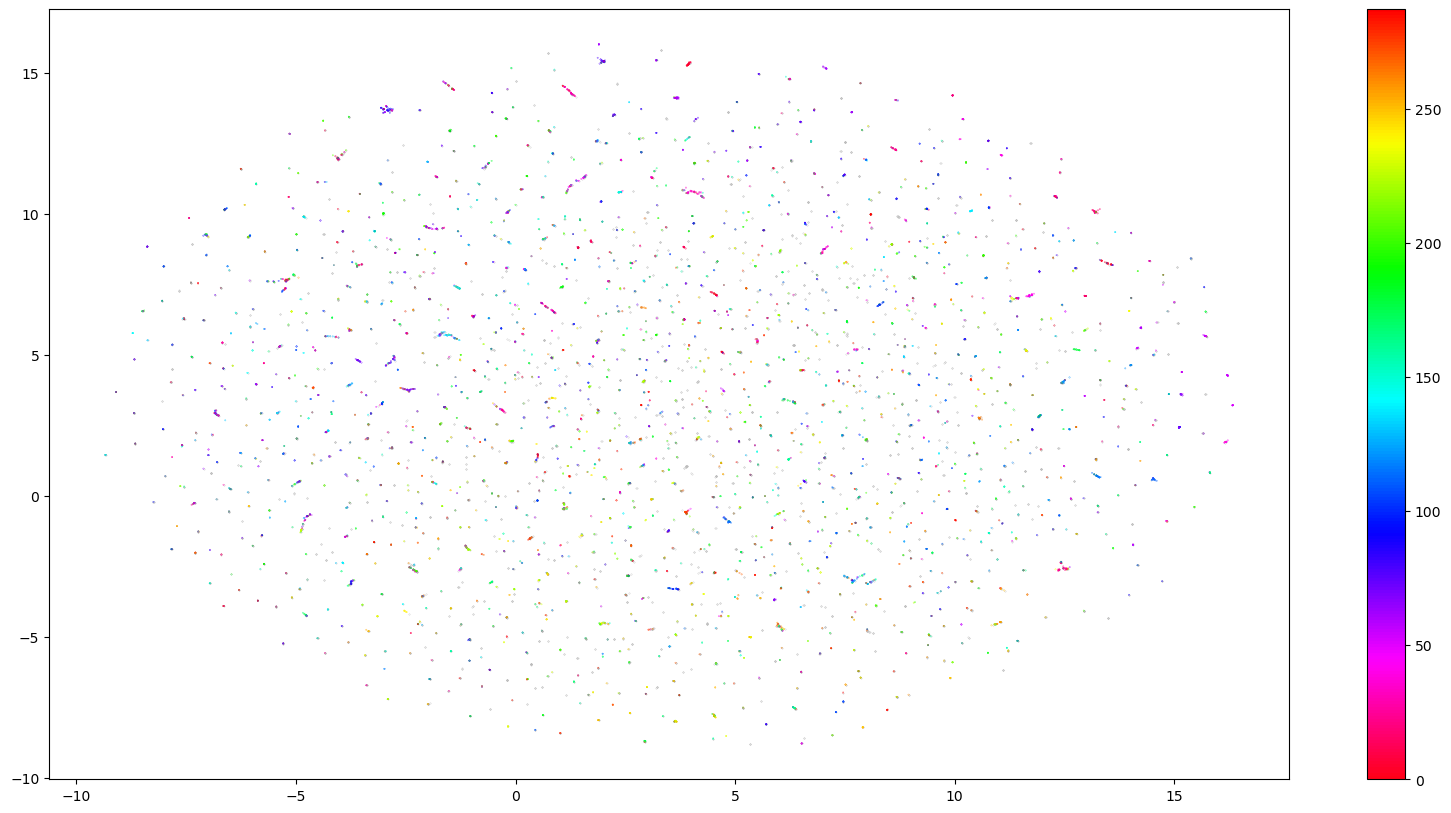


done with plot
     Topic  Size
0       -1  5225
253    252    77
157    156    77
170    169    75
25      24    73
36      35    68
215    214    66
11      10    60
79      78    60
16      15    59
289
77 [('amp', 0.06606519381409232), ('help', 0.05437810764628078), ('seat', 0.05350041075265715), ('home', 0.04637833080883223), ('thank', 0.046239963388361734), ('usairways', 0.044327533280298745), ('free', 0.03745485094766954), ('pay', 0.03663289593559974), ('hotel', 0.0363039058245542), ('premium', 0.035877788601749484)]
77 [('email', 0.09819666961400474), ('online', 0.0632304262518933), ('customer', 0.052204264849804866), ('help', 0.05216210563339575), ('baggage', 0.04881631888934665), ('luggage', 0.04723137654365499), ('service', 0.0393208074603739), ('poor', 0.037611822121876755), ('helpful', 0.03671891646720409), ('bag', 0.03445715449873424)]
75 [('sit', 0.080792549764172), ('hour', 0.07600882724351302), ('plane', 0.056222610887280394), ('wait', 0.055562720452579956), ('amp', 0

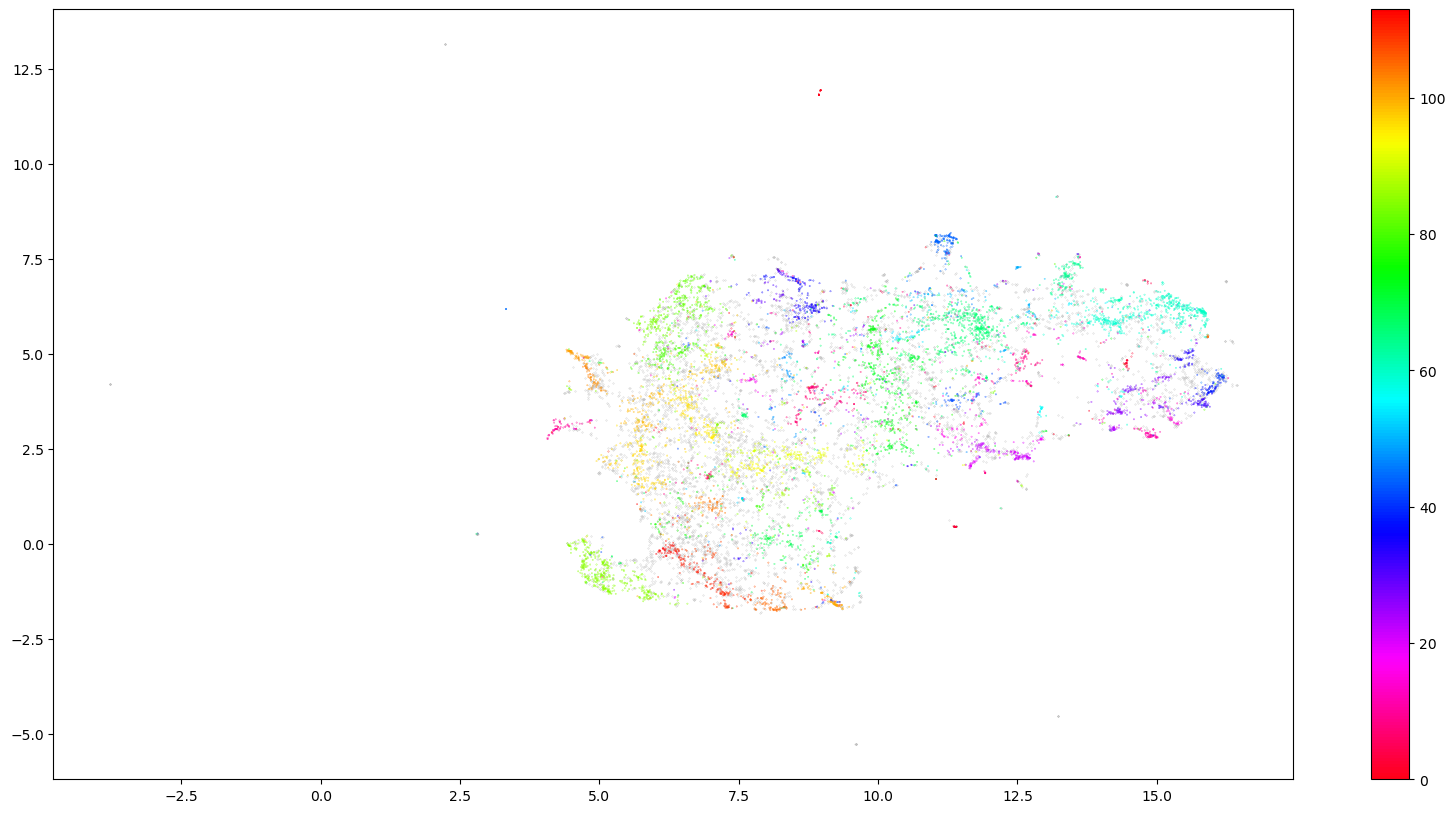


done with plot
    Topic  Size
0      -1  6380
67     66   588
86     85   468
61     60   329
73     72   253
83     82   239
60     59   225
98     97   194
93     92   164
81     80   152
115
588 [('great', 0.06768043991905842), ('thank', 0.06757013933931895), ('flight', 0.0529977146127603), ('good', 0.05100216033272196), ('fly', 0.049793953781383966), ('love', 0.0443712050933251), ('airline', 0.04025743708871061), ('crew', 0.035323884807897984), ('jetblue', 0.03219620416745033), ('guy', 0.028576322464130912)]
468 [('fly', 0.061173334424531677), ('service', 0.03817606219390054), ('usairway', 0.03767839749099918), ('customer', 0.03351602906105355), ('usairways', 0.03342768746737717), ('zero', 0.033347821243532805), ('airline', 0.033061330368531934), ('united', 0.027689743266244096), ('hour', 0.02722273019368217), ('flight', 0.02709341165566726)]
329 [('thank', 0.33657838036059523), ('appreciate', 0.11099397122519059), ('response', 0.09364214574615348), ('quick', 0.06945332605371833)

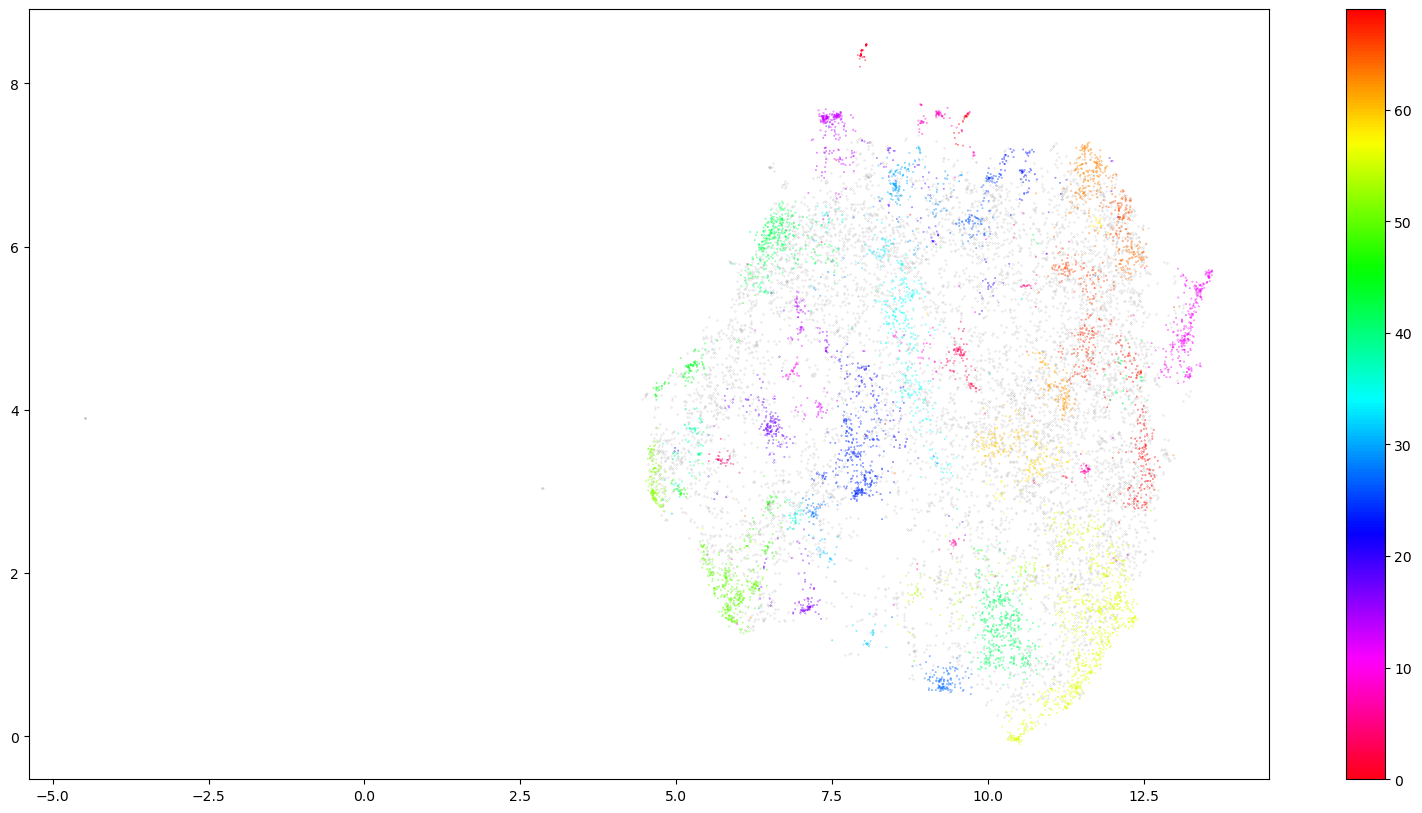


done with plot
    Topic  Size
0      -1  7362
57     56   756
42     41   461
51     50   326
25     24   316
43     42   297
12     11   287
35     34   269
14     13   202
64     63   193
71
756 [('bad', 0.0940265016879614), ('customer', 0.07386240908847741), ('service', 0.07273979360023683), ('rude', 0.04990775662573785), ('experience', 0.04531149404135199), ('airline', 0.043601055374858345), ('terrible', 0.034861261728754166), ('usairways', 0.0325012959404817), ('usairway', 0.031886638574744164), ('horrible', 0.02742180138687153)]
461 [('fly', 0.06100982534398218), ('service', 0.04243641276224443), ('customer', 0.04054293391426756), ('usairways', 0.03814701736253258), ('usairway', 0.03675528029101192), ('airline', 0.035476463967379884), ('zero', 0.027883545218490187), ('flight', 0.027688179215257066), ('hour', 0.02652636747088467), ('bag', 0.024741607385099656)]
326 [('dm', 0.2654977357138576), ('follow', 0.216087682568621), ('send', 0.09786172176928952), ('message', 0.0535382642

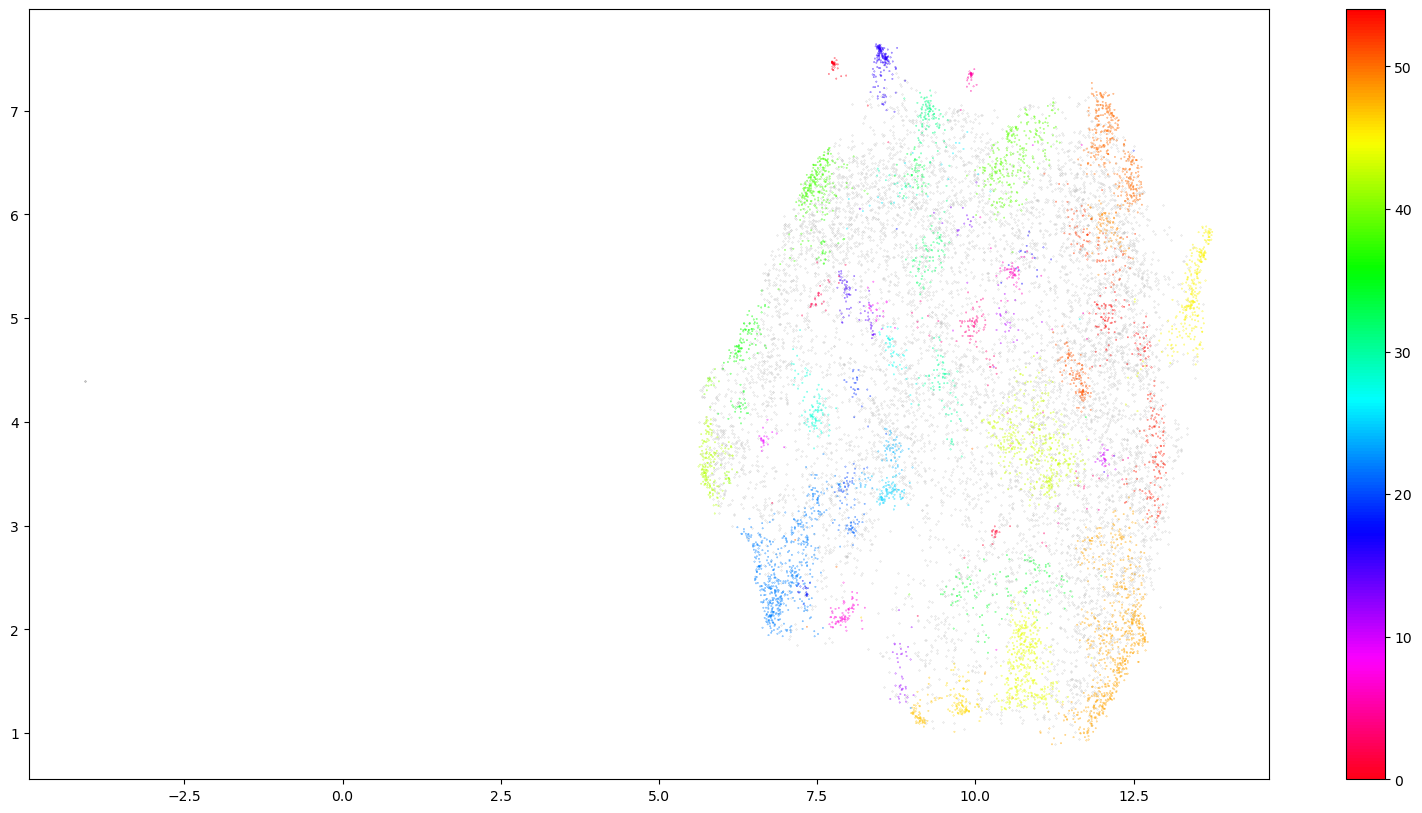


done with plot
    Topic  Size
0      -1  7799
49     48   688
23     22   552
44     43   411
45     44   408
51     50   347
40     39   286
46     45   272
39     38   250
17     16   173
56
688 [('bad', 0.09034018327356116), ('customer', 0.0735438639636078), ('service', 0.06856253908718563), ('rude', 0.05102507162596129), ('airline', 0.04895777315604393), ('experience', 0.038400225930627724), ('terrible', 0.037773236521601104), ('usairways', 0.03192409420340769), ('usairway', 0.03050704021922697), ('flight', 0.030003065972166874)]
552 [('dm', 0.13895716575741943), ('follow', 0.10543721893896554), ('need', 0.0871757843646761), ('help', 0.061638850224692066), ('send', 0.05500655894795653), ('usairway', 0.05041433341231789), ('usairways', 0.040825110897657856), ('try', 0.04066399387131959), ('say', 0.036234774361739816), ('reservation', 0.035190163648054495)]
411 [('cancel', 0.20258740575935189), ('flight', 0.1508258291670946), ('flightle', 0.11657789367937163), ('delay', 0.042767983

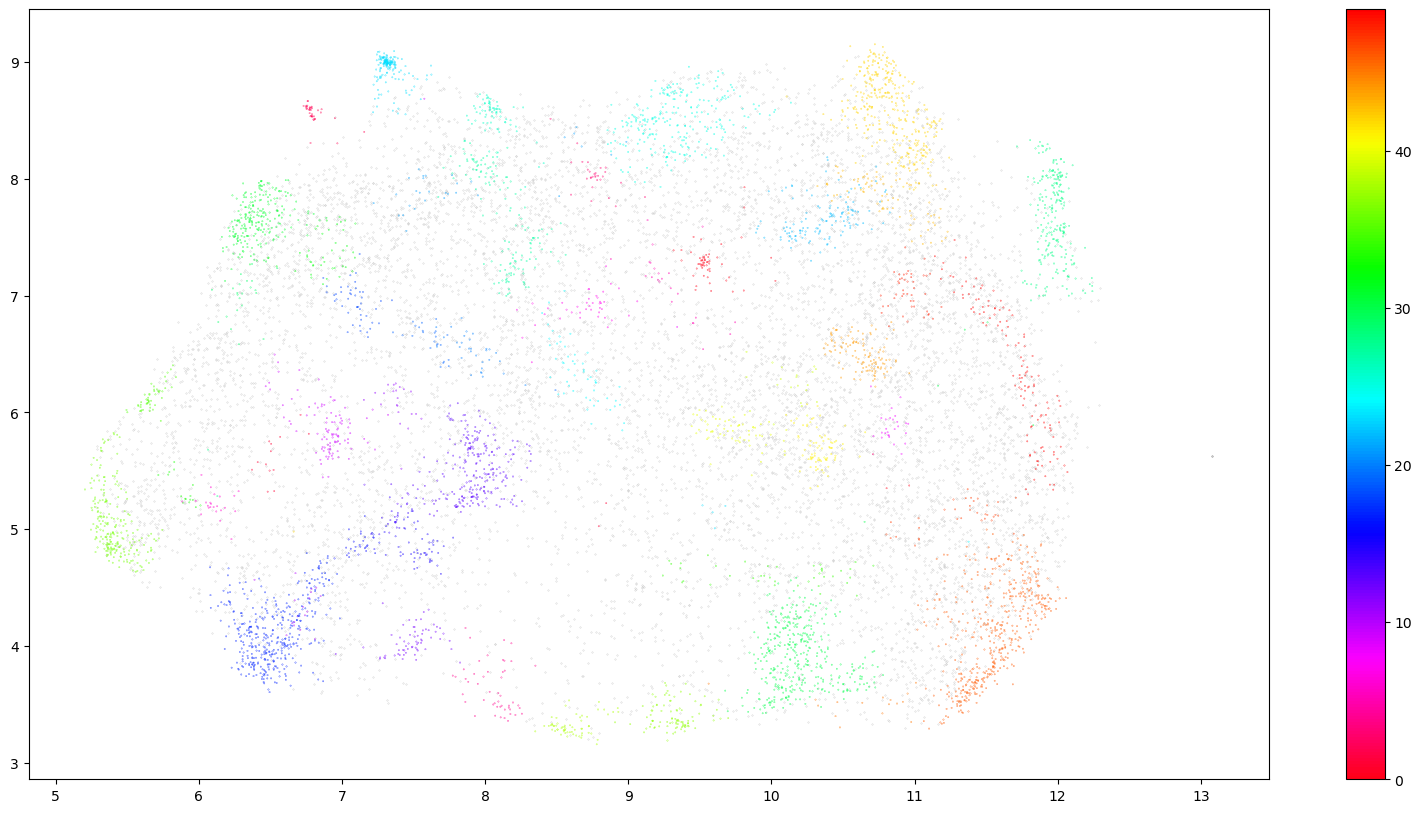


done with plot
    Topic  Size
0      -1  8671
47     46   475
31     30   389
18     17   385
43     42   338
14     13   249
26     25   249
29     28   237
32     31   234
37     36   230
51
475 [('bad', 0.11223471895357978), ('customer', 0.09363821628236448), ('service', 0.09293554742328802), ('rude', 0.07054949214297923), ('airline', 0.053111521619859846), ('experience', 0.0497983501417014), ('terrible', 0.04766241257333227), ('usairways', 0.037875402955652455), ('horrible', 0.03388727699247851), ('usairway', 0.03189914608183396)]
389 [('fly', 0.06803190370379587), ('service', 0.043926338499931494), ('airline', 0.04316619416464147), ('customer', 0.04153760507716919), ('usairways', 0.0399228985021295), ('usairway', 0.03744184301152279), ('united', 0.028991848739582115), ('neveragain', 0.026764940678911702), ('flight', 0.026325016555303952), ('zero', 0.025774354055042564)]
385 [('dm', 0.22243260294609501), ('follow', 0.17444228065328926), ('send', 0.07893418720659338), ('need', 0.0

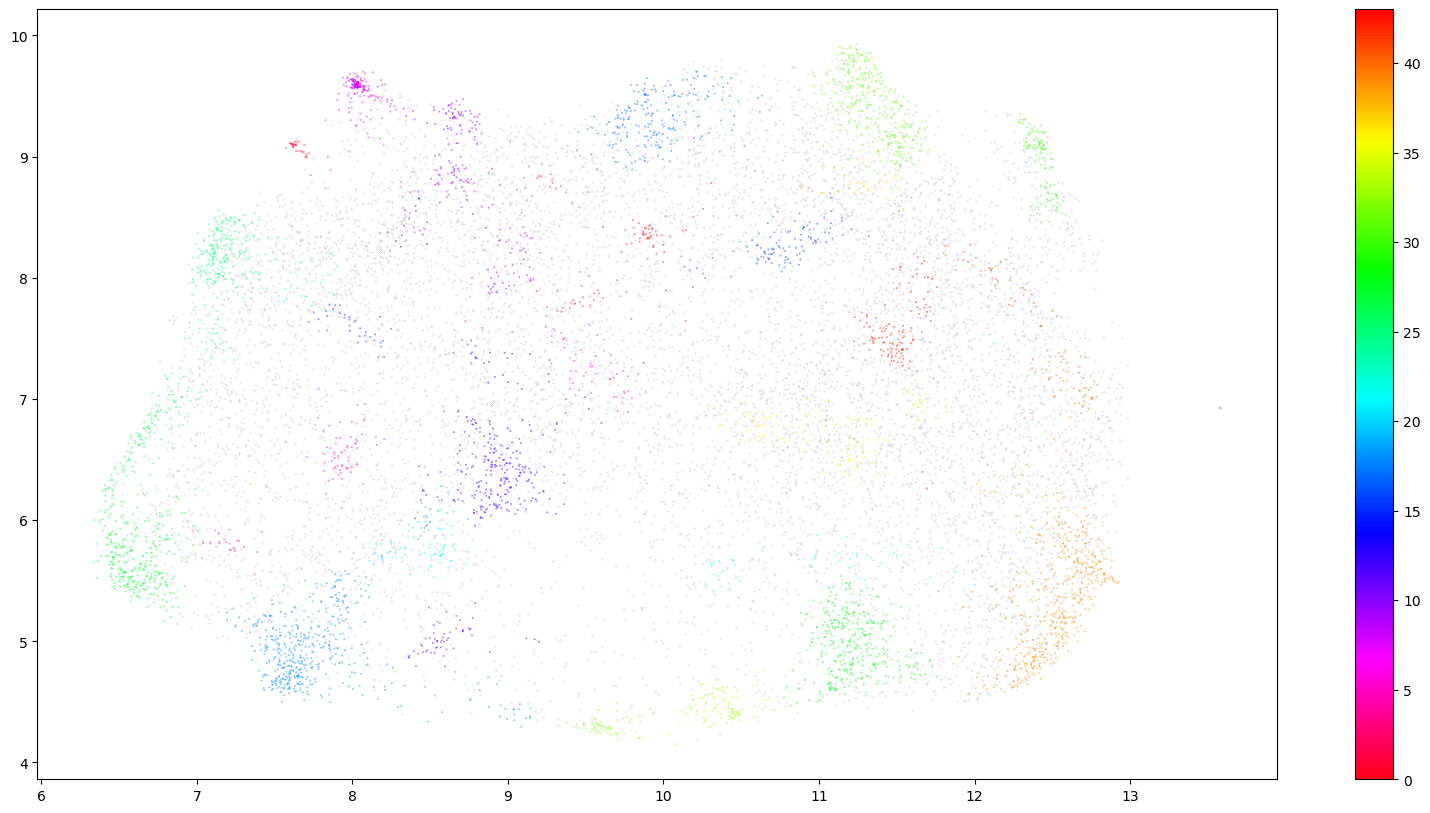


done with plot
    Topic  Size
0      -1  9096
19     18   476
40     39   475
29     28   367
28     27   352
32     31   349
13     12   256
26     25   233
18     17   215
9       8   168
45
476 [('dm', 0.1869824483973076), ('follow', 0.14312744652348264), ('need', 0.069256928309894), ('send', 0.0685466349966843), ('usairway', 0.05643764984292215), ('usairways', 0.046381191078995916), ('say', 0.04580851073156404), ('know', 0.04325859039298822), ('help', 0.042673050155556044), ('try', 0.03753599434275655)]
475 [('bad', 0.11273309455083795), ('customer', 0.09666394095815516), ('service', 0.0959128114928663), ('rude', 0.06917649048819663), ('airline', 0.055288580851475845), ('terrible', 0.048218474053354485), ('experience', 0.04456633117489059), ('horrible', 0.03673138774006152), ('usairways', 0.035692811241952296), ('usairway', 0.03119559269325129)]
367 [('fly', 0.06936975919888383), ('airline', 0.045379870657976516), ('service', 0.042900858512927256), ('customer', 0.0420250235549825

In [8]:
# MAIN
# def plot(embeddings, n_neighbors, n_components=5, min_dist=0.0, min_cluster_size=5):
chng_neigh = [[2, 5, 0.0, 15, 'test1'],
			  [5, 5, 0.0, 15, 'test2'],
			  [10, 5, 0.0, 15, 'test3'],
			  [20, 5, 0.0, 15, 'test4'],
			  [50, 5, 0.0, 15, 'test5'],
			  [100, 5, 0.0, 15, 'test6']]


for i in range(len(chng_neigh)):
	docs_per_topic, top_n_words, topic_sizes = plot(embeddings, chng_neigh[i][0], chng_neigh[i][1], chng_neigh[i][2], chng_neigh[i][3])
	write_results(i, topic_sizes, top_n_words, chng_neigh)

In [9]:
'''
docs_per_topic, top_n_words, topic_sizes = plot(embeddings, 100, 5, 0.0, 15)
fn = 'test1'

write_results(0, topic_sizes, top_n_words, [[100, 5, 0.0, 15, 'test1']])
'''

"\ndocs_per_topic, top_n_words, topic_sizes = plot(embeddings, 100, 5, 0.0, 15)\nfn = 'test1'\n\nwrite_results(0, topic_sizes, top_n_words, [[100, 5, 0.0, 15, 'test1']])\n"